In [145]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from sparse_causal_model_learner_rl.trainable.model import LinearModel
from sparse_causal_model_learner_rl.trainable.reconstructor import LinearReconstructor
from sparse_causal_model_learner_rl.trainable.decoder import LinearDecoder
from sparse_causal_model_learner_rl.visual.learner_visual import plot_model
from sparse_causal_model_learner_rl.loss.losses import MfMa

# Learning a basis where the matrix is most sparse

We have a dynamical system with $o_{t+1}=W_oo_{t}+W_aa_{t}$, and we want to find a space $f=Do$ with $S(DW_a)+S(DW_oD^{\dagger})\to\min$. In Sparse Dictionary Learning, we use a reconstructor $R$ and optimize $\|W_o-RM_oR^{\dagger}\|_F^2+\lambda\|M_o\|_1\to\min$ and $\|W_a-RM_a\|_F^2+\lambda\|M_a\|_1\to\min$. The second term will try to make $R$ larger, so we additionally add $\|R\|_F^2\to\min$

In [468]:
# state dim = number of actions
s = 10

# observation dim
o = 20

# feature dim
f = 10

# state/action model
As = np.eye(s)
Aa = np.eye(s)

# encoder
E = np.random.randn(o, s)

# number of observations
N = 1000

# data
states = np.random.randn(N, s)
actions = np.random.randn(N, s)
next_states = states @ As + actions @ Aa

# encoding
obs_x = states @ E.T
obs_y = next_states @ E.T
act_x = actions

# world model
Wo = E @ As @ np.linalg.pinv(E)
Wa = E @ Aa

In [470]:
np.max(np.abs(states + act_x - next_states)), np.max(np.abs(obs_x + act_x - obs_y))

ValueError: operands could not be broadcast together with shapes (1000,20) (1000,10) 

In [481]:
Wo.shape, Wa.shape

((20, 20), (20, 10))

# Explicit expression for the model

In [490]:
Wo_torch = torch.tensor(Wo, requires_grad=False, dtype=torch.float32)
Wa_torch = torch.tensor(Wa, requires_grad=False, dtype=torch.float32)

In [491]:
decoder = LinearDecoder(use_bias=False, feature_shape=(f,), observation_shape=(o,))
model = LinearModel(use_bias=False, feature_shape=(f, ), action_shape=(s, ))

In [492]:
opt = torch.optim.Adam(decoder.parameters())

In [493]:
D = decoder.fc.weight

In [494]:
losses = {}
epoch = 0
def add_loss(key, val):
    if key not in losses:
        losses[key] = []
    losses[key].append(val)

In [495]:
for i in tqdm(range(10000)):
    opt.zero_grad()
    
    Dinv = torch.pinverse(D)
    Ma = D @ Wa_torch
    Mf = D @ Wo_torch @ Dinv
    
    loss = torch.norm(Ma.flatten(), p=1) + torch.norm(Mf.flatten(), p=1) + torch.norm(torch.inverse(Ma).flatten(), p=1) + torch.norm(torch.inverse(Mf).flatten(), p=1)#+ 0.01 * torch.norm(Dinv)
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
        add_loss('sparse', loss.item())
    epoch += 1
    

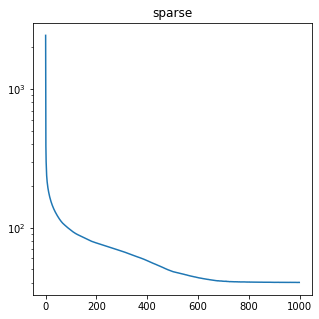

In [496]:
plt.figure(figsize=(5, 5))

for i, (key, arr) in enumerate(losses.items(), 1):
    plt.subplot(1, len(losses), i)
    plt.title(key)
    plt.yscale('log')
    plt.plot(arr, label=key)
#plt.yscale('log')
#plt.legend()
plt.show()

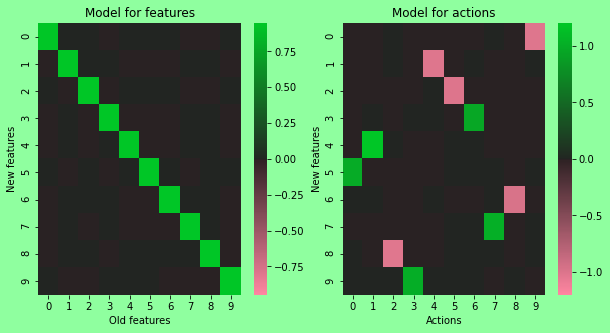

In [498]:
model.load_state_dict({'fc_action.weight': Ma, 'fc_features.weight': Mf})
_ = plot_model(model)

In [426]:
torch.norm(torch.pinverse(Ma).flatten())

tensor(4.6651, grad_fn=<NormBackward0>)

In [364]:
torch.norm(D)

tensor(1.0689, grad_fn=<NormBackward0>)

In [365]:
torch.norm(torch.pinverse(D))

tensor(49.3423, grad_fn=<NormBackward0>)

# Linear regression with PyTorch using a reconstructor

In [134]:
model = LinearModel(use_bias=False, feature_shape=(f, ), action_shape=(s, ))
reconstructor = LinearReconstructor(use_bias=False, feature_shape=(f,), observation_shape=(o,))

In [135]:
opt1 = torch.optim.Adam(model.parameters())
opt2 = torch.optim.Adam(reconstructor.parameters())

In [136]:
Wo_torch = torch.tensor(Wo, requires_grad=False, dtype=torch.float32)
Wa_torch = torch.tensor(Wa, requires_grad=False, dtype=torch.float32)

In [137]:
losses = {}
epoch = 0
def add_loss(key, val):
    if key not in losses:
        losses[key] = []
    losses[key].append(val)

In [138]:
class PID(object):
    def __init__(self, P, I, D, clamp=1, maxI=1, maxD=1):
        self.P = P
        self.I = I
        self.D = D
        self.clamp = clamp
        self.integral = 0
        self.last_value = 0
        self.maxI = maxI
        self.maxD = maxD
        
    def __call__(self, val):
        self.current_val = val
        res = self.comp_P() + self.comp_I() + self.comp_D()
        if res > self.clamp:
            res = self.clamp
        if res < -self.clamp:
            res = -self.clamp
        return res
        
    def comp_P(self):
        return self.current_val * self.P
    
    def comp_I(self):
        self.integral += self.current_val
        if self.integral > self.maxI:
            self.integral = self.maxI
        if self.integral < -self.maxI:
            self.integral = -self.maxI
            
        return self.integral * self.I
    
    def comp_D(self):
        delta = self.current_val - self.last_value
        if delta > self.maxD:
            delta = self.maxD
        if delta < -self.maxD:
            delta = -self.maxD
        return delta * self.D

In [139]:
pid = PID(P=-0.001, I=-0.01, D=0, clamp=5)

In [140]:
Wo_torch

tensor([[ 1.0000e+00, -6.8250e-16, -5.8547e-16, -4.7336e-17, -2.7430e-16],
        [-3.3589e-16,  1.0000e+00,  1.0811e-15,  4.6927e-16, -1.4715e-16],
        [-8.6371e-17, -3.6507e-16,  1.0000e+00, -5.7039e-16,  3.7531e-17],
        [ 1.1209e-16, -1.5919e-16, -4.5696e-16,  1.0000e+00, -2.0430e-16],
        [-1.1833e-16,  1.7602e-16,  1.8235e-16,  9.4920e-17,  1.0000e+00]])

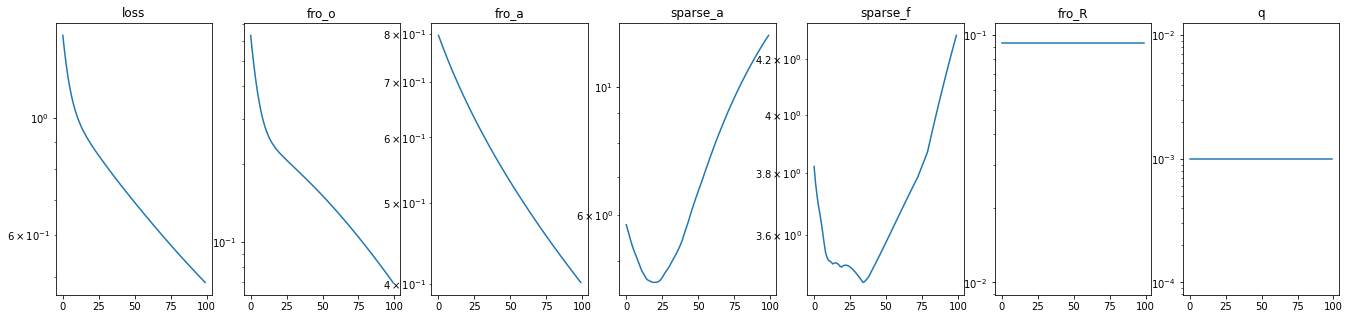

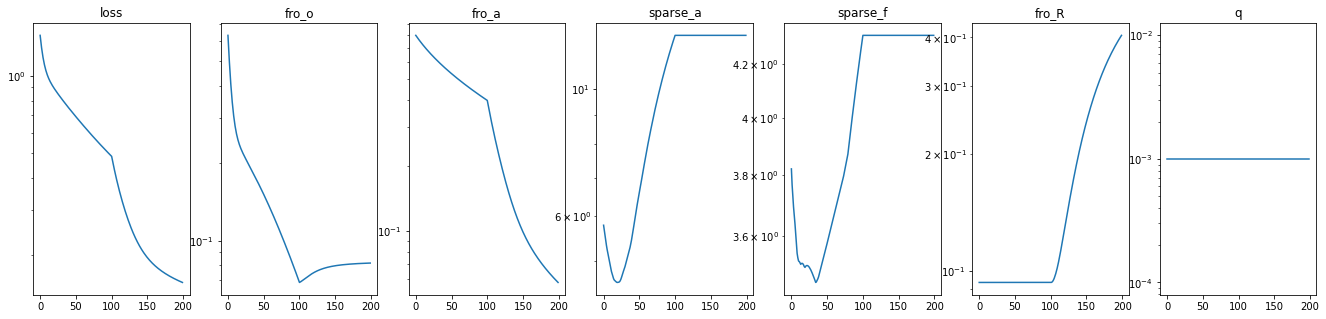

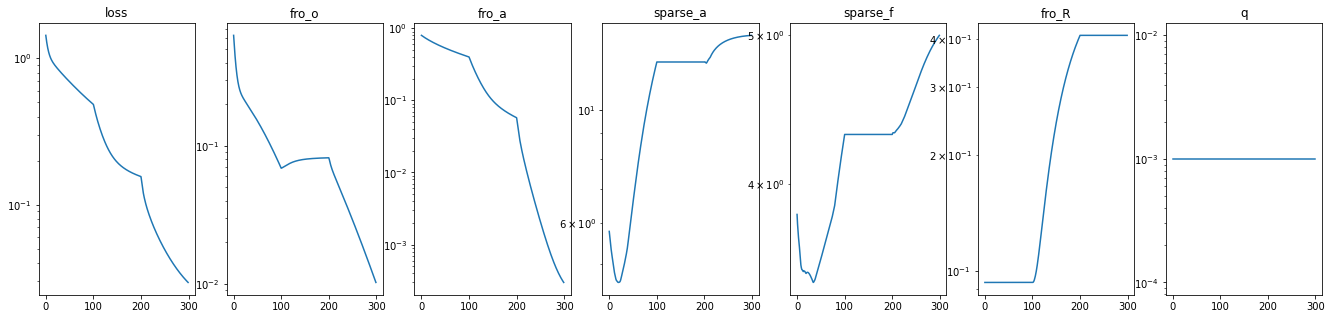

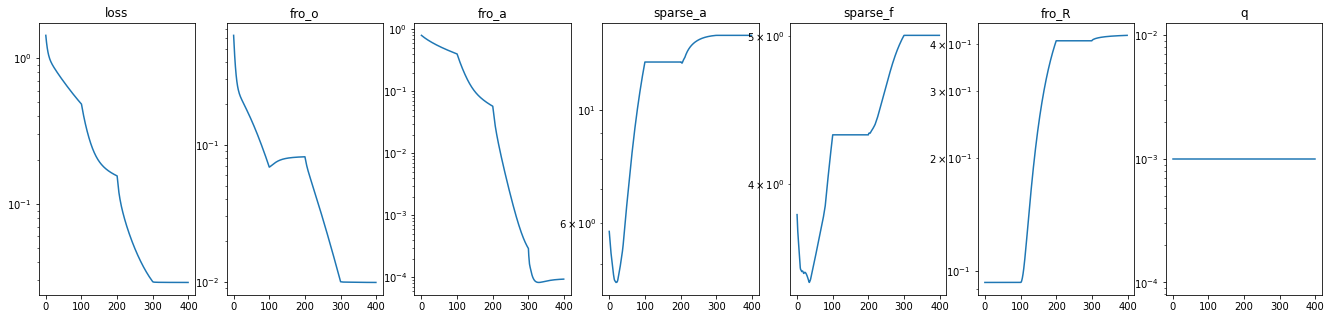

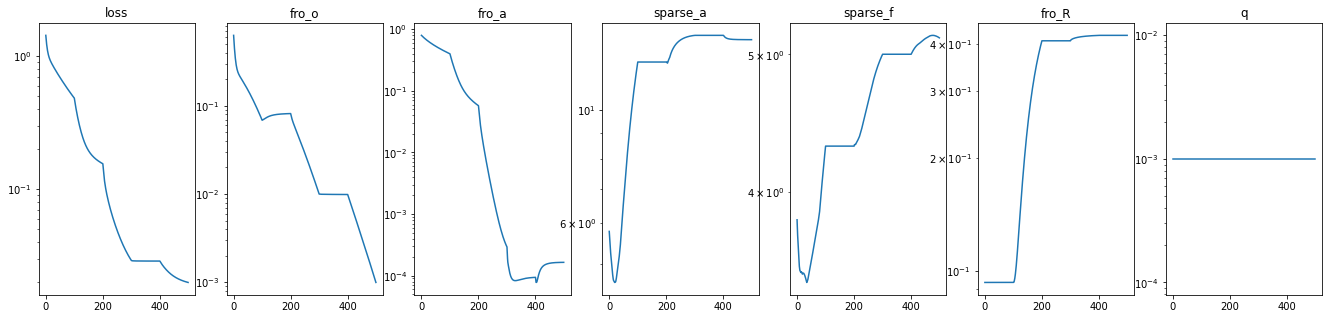

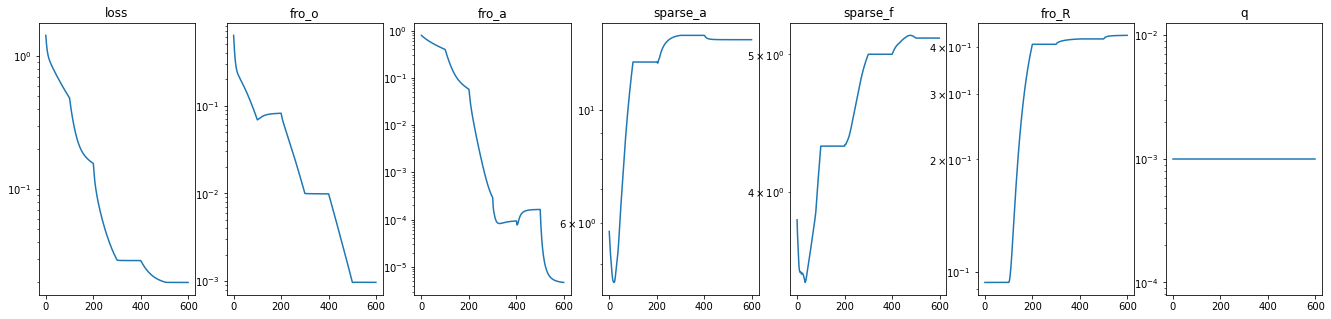

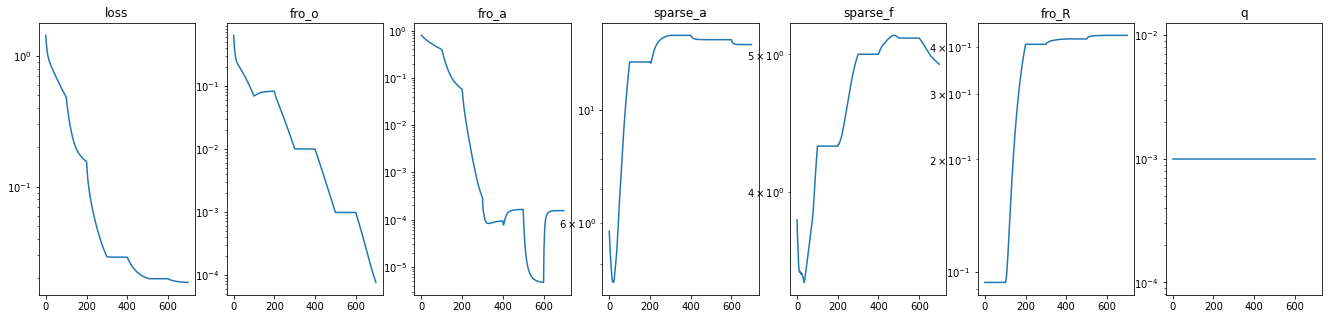

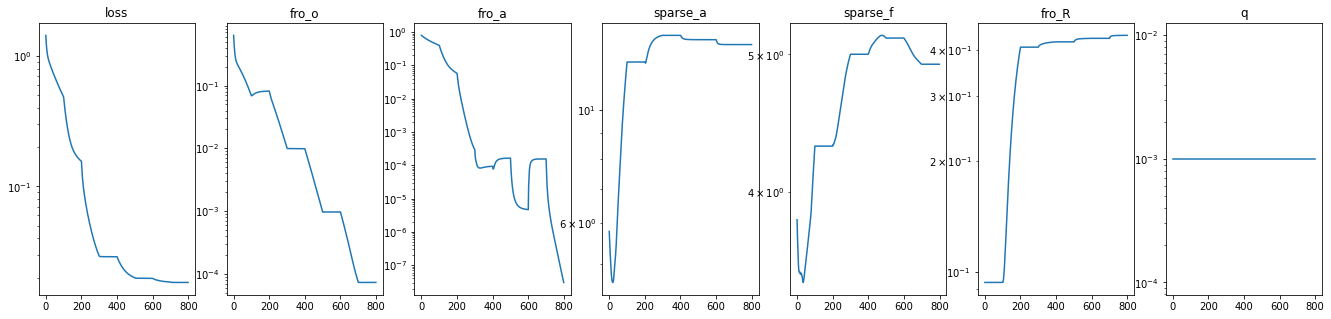

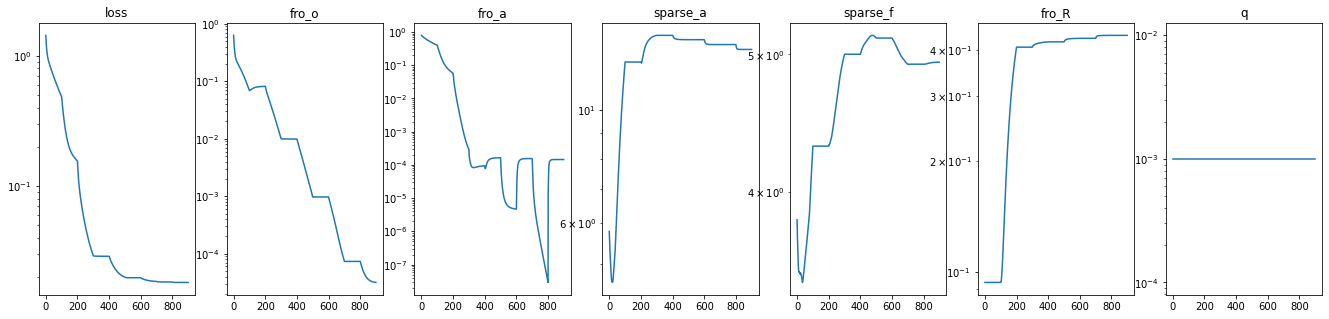

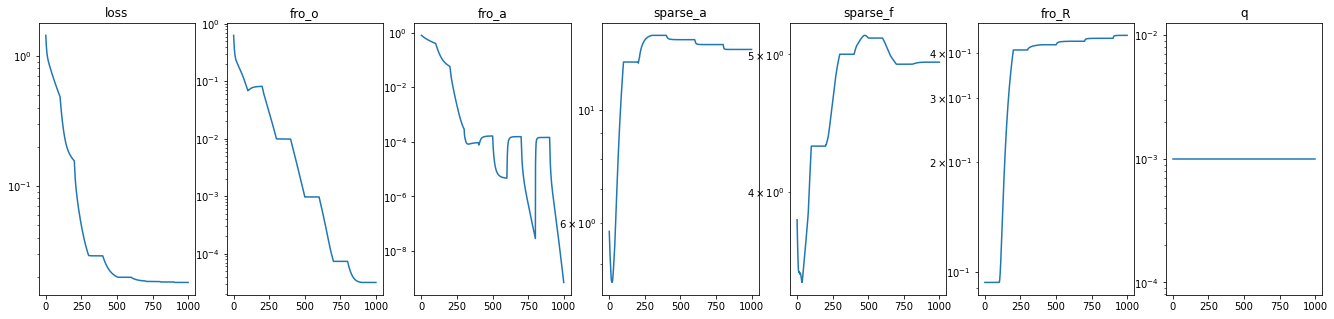

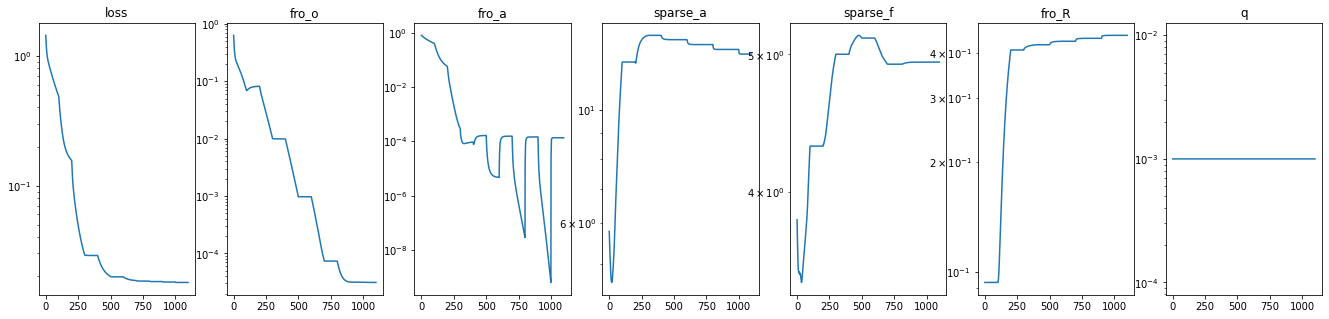

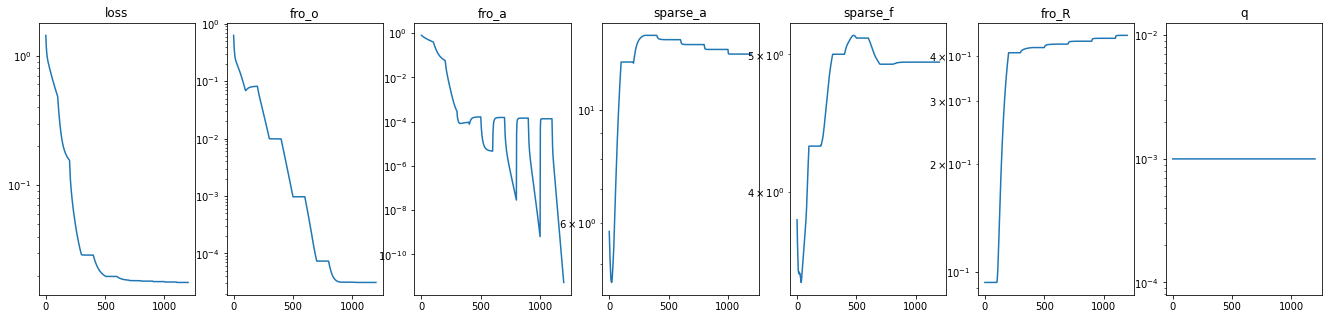

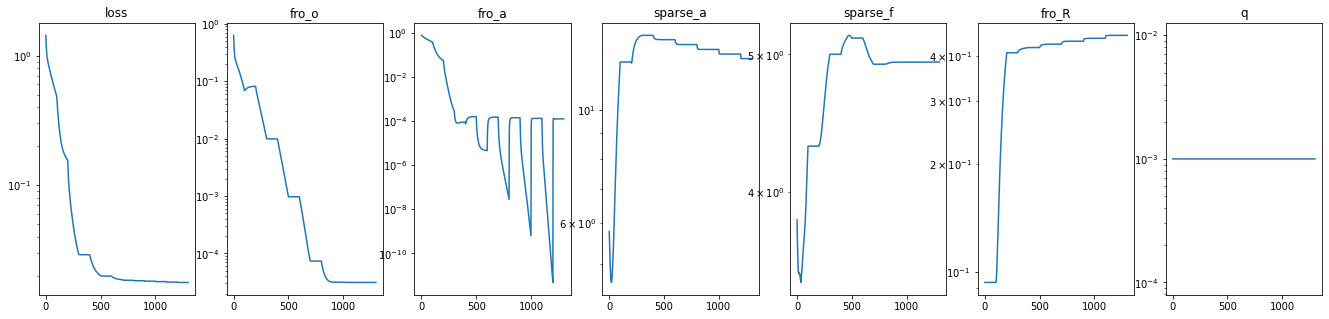

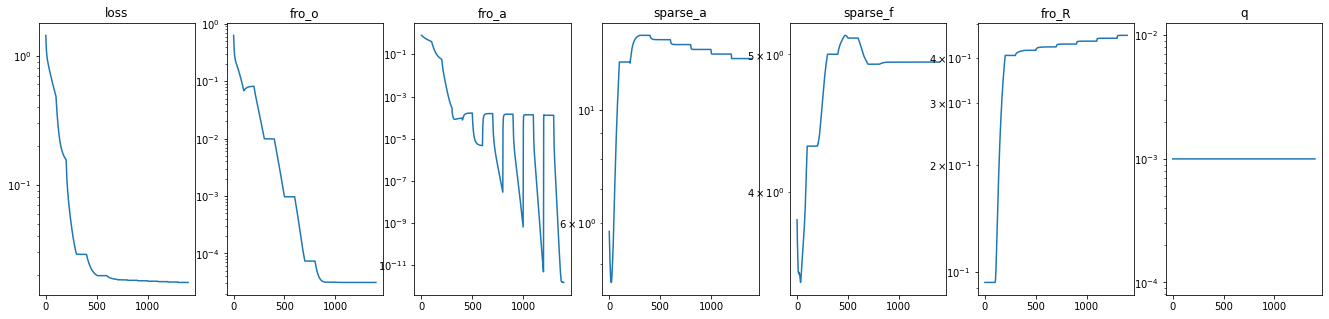

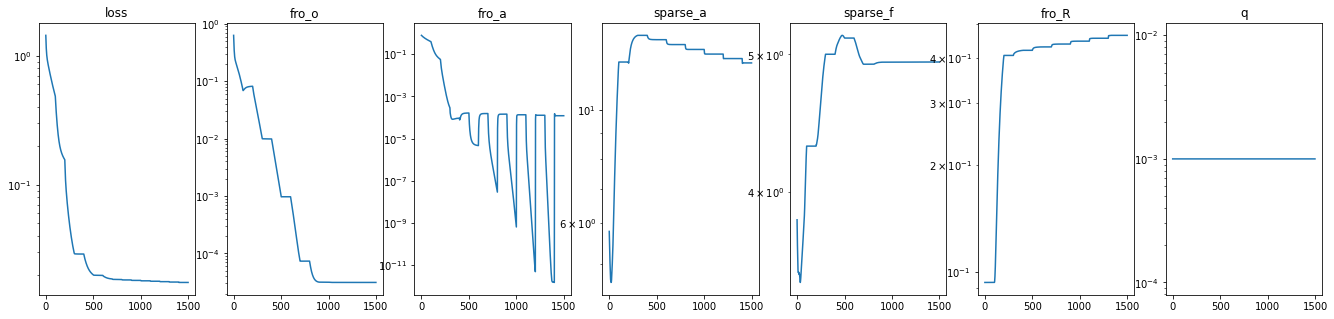

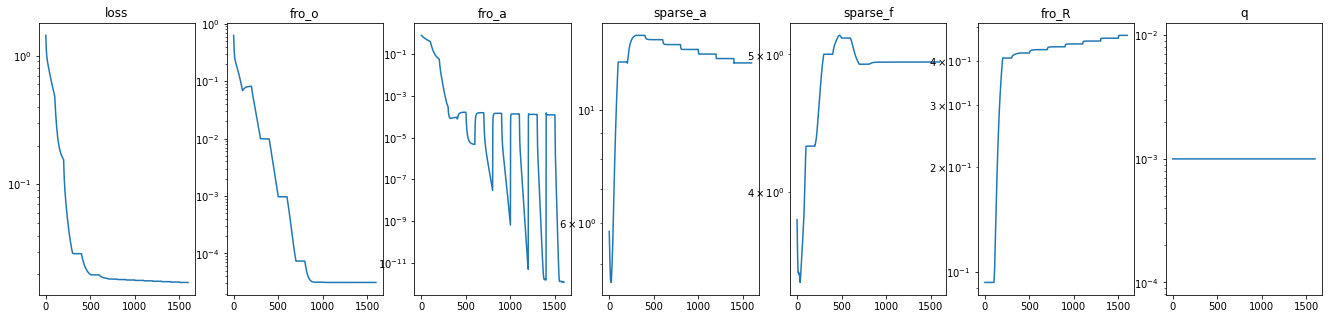

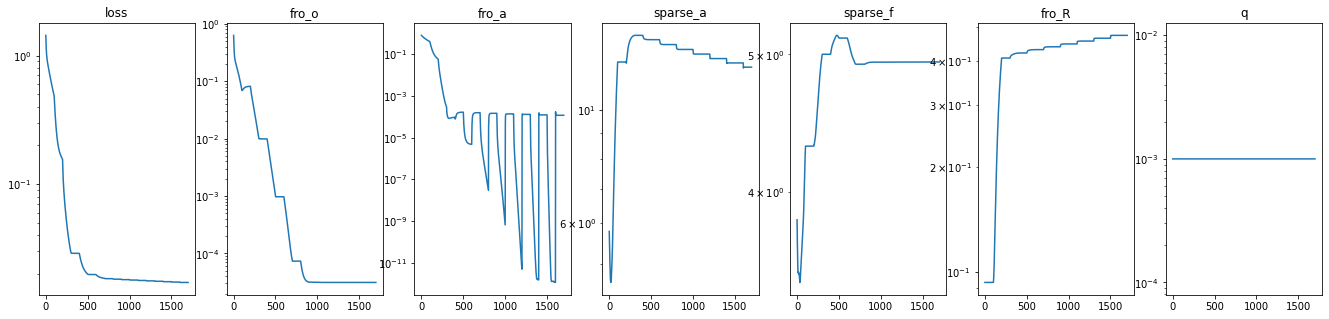

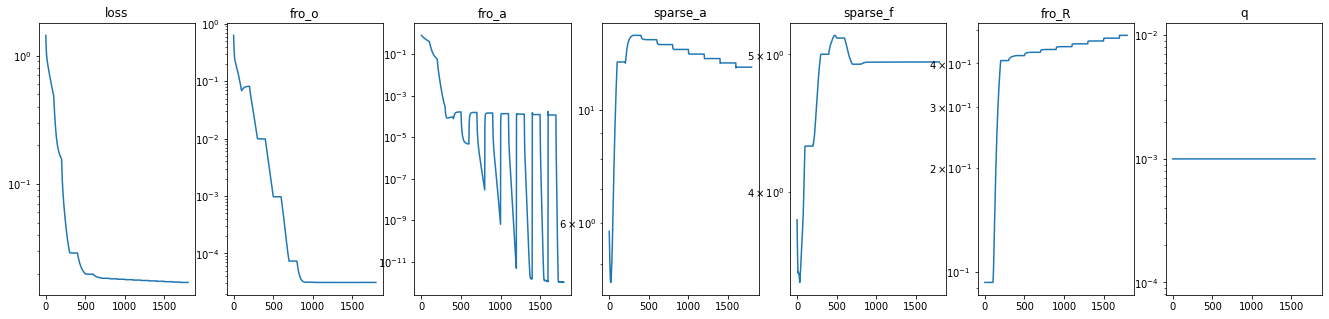

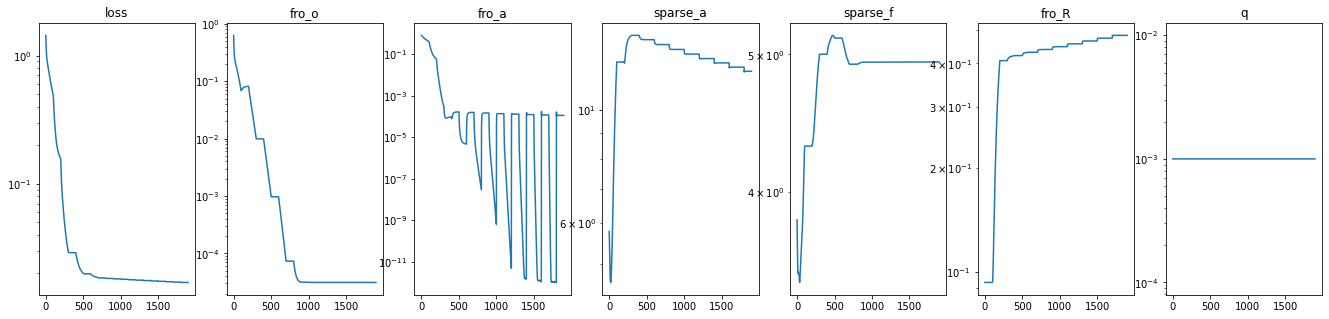

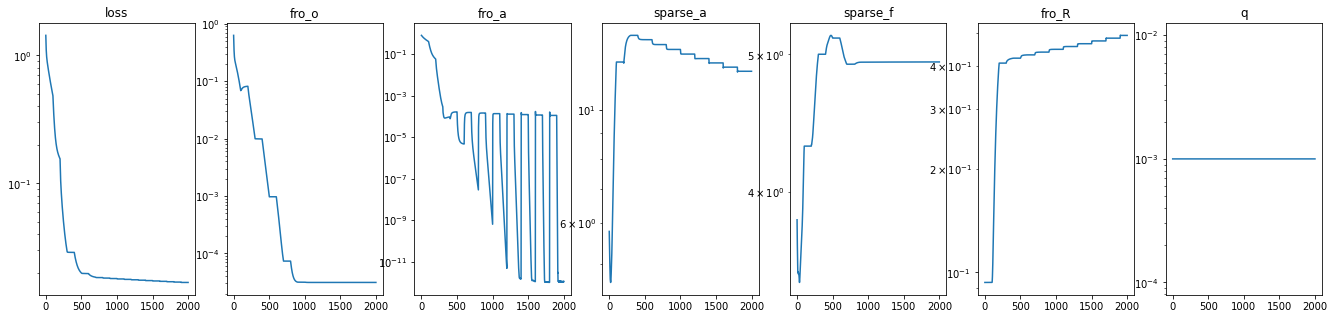

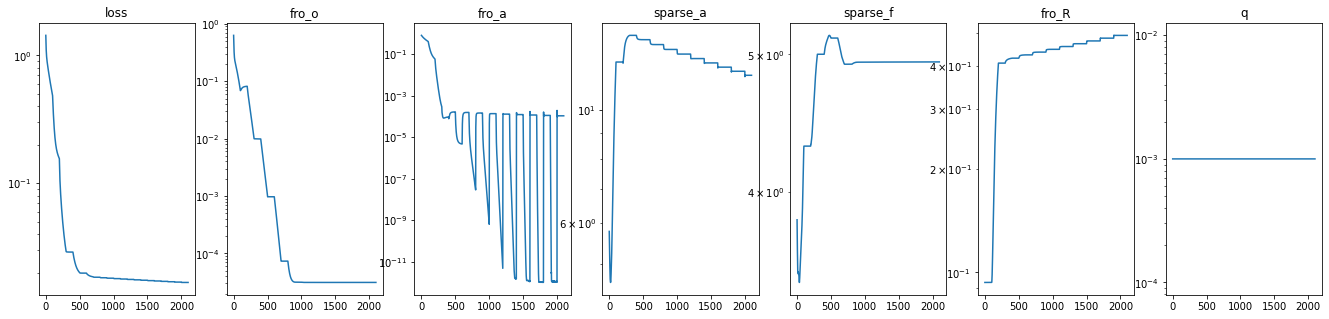

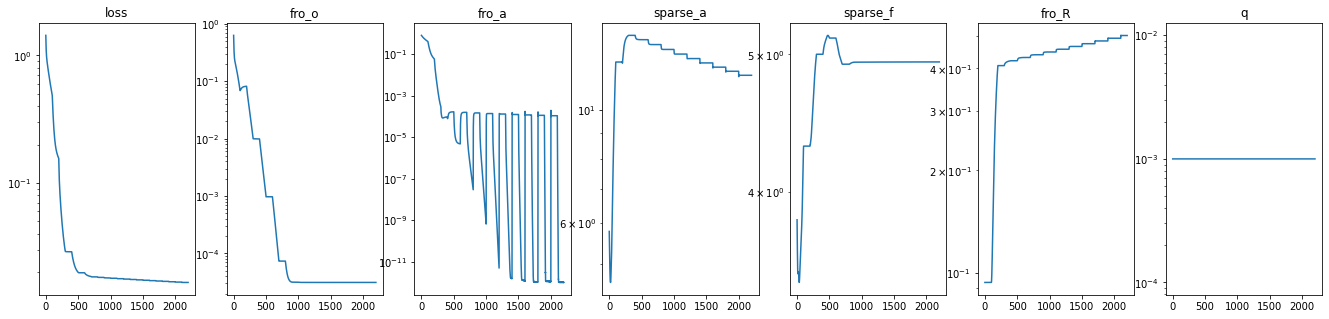

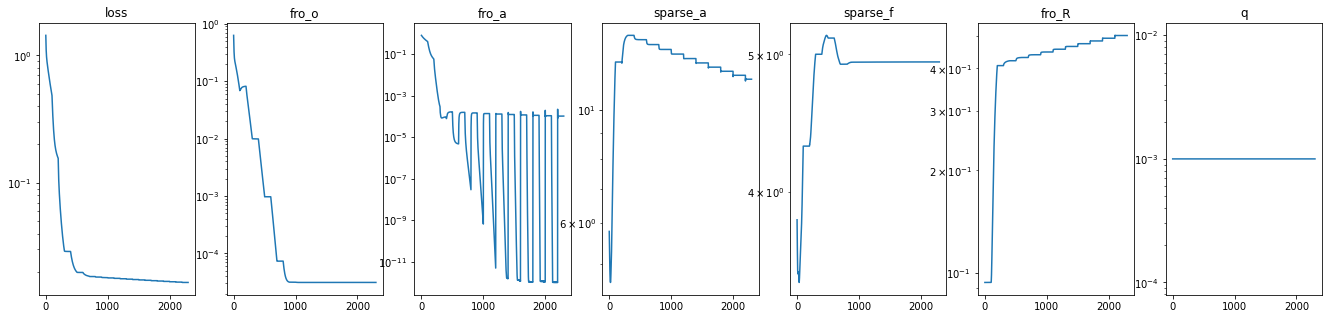

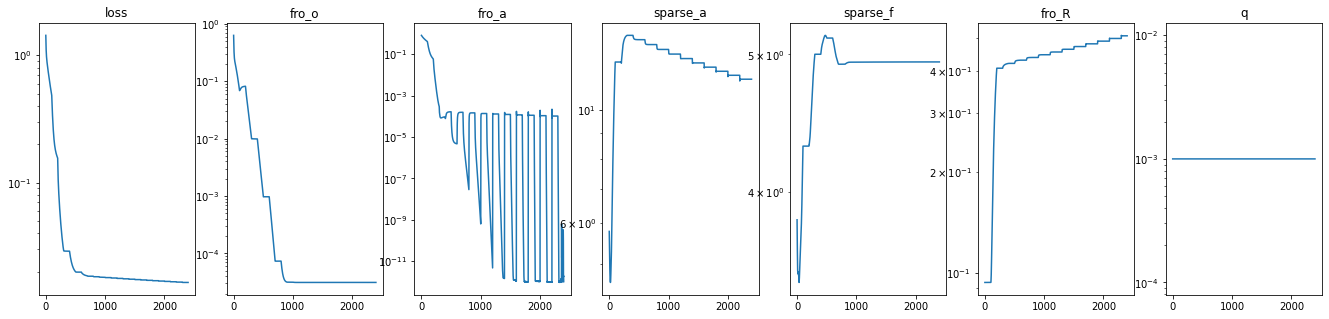

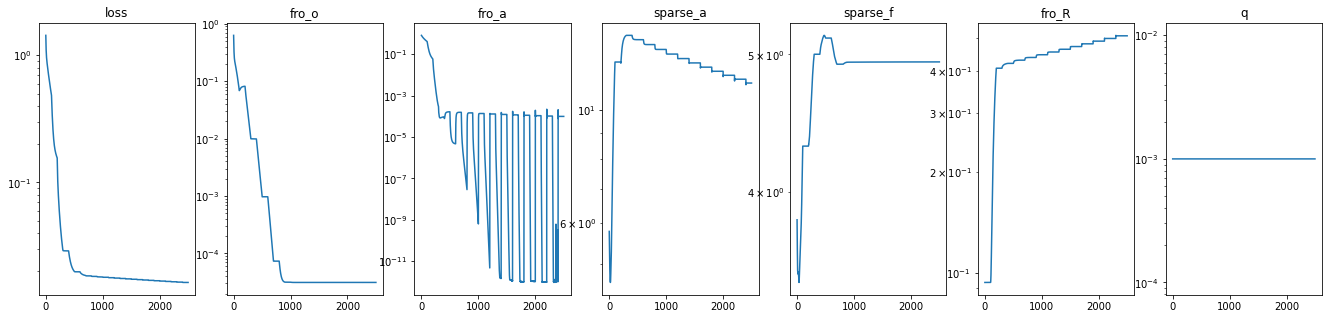

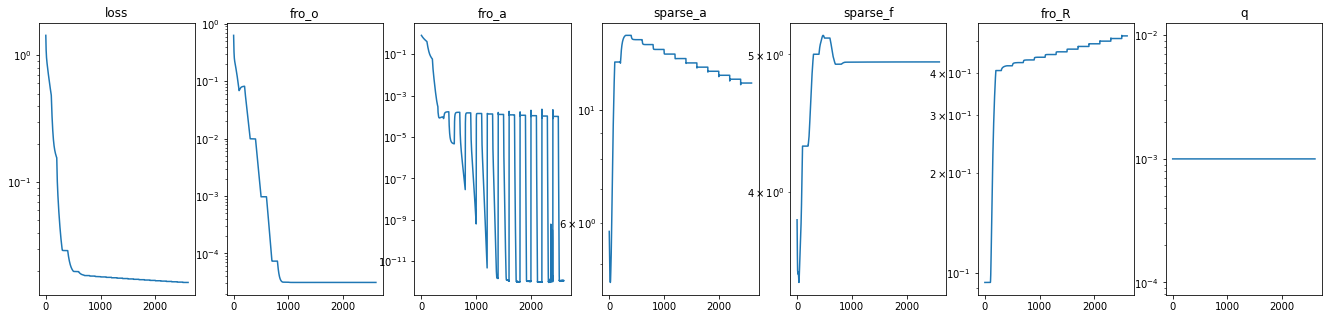

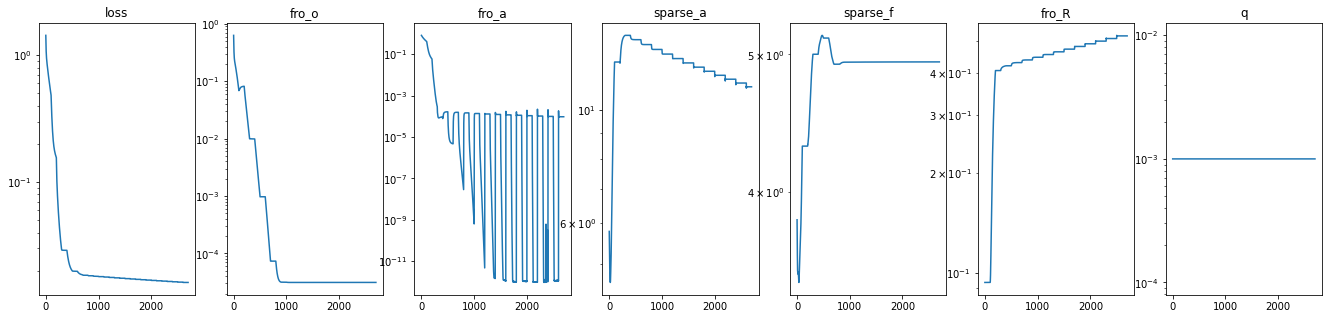

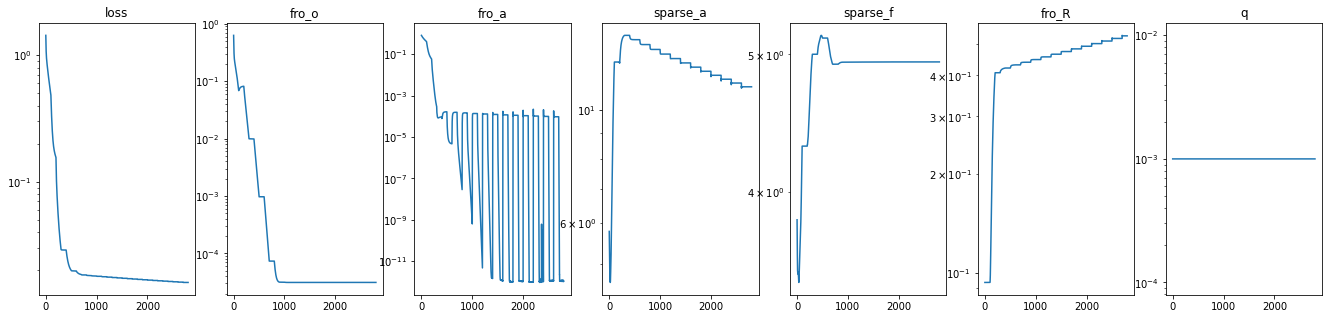

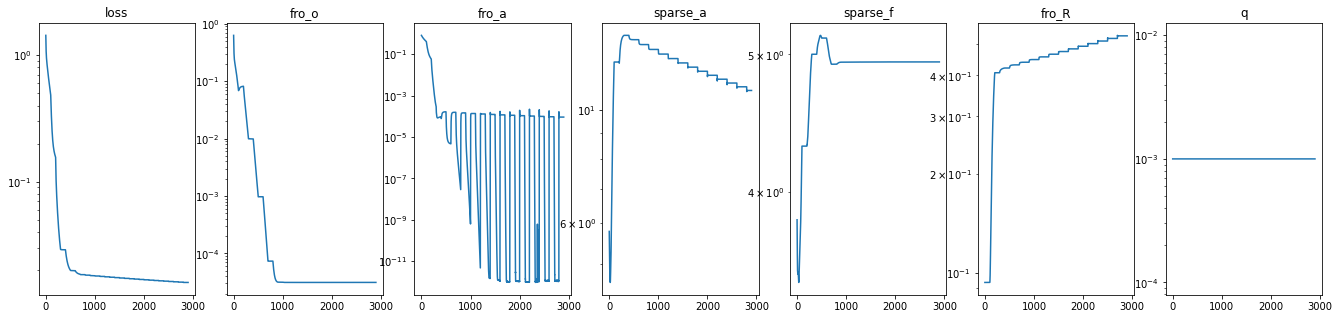

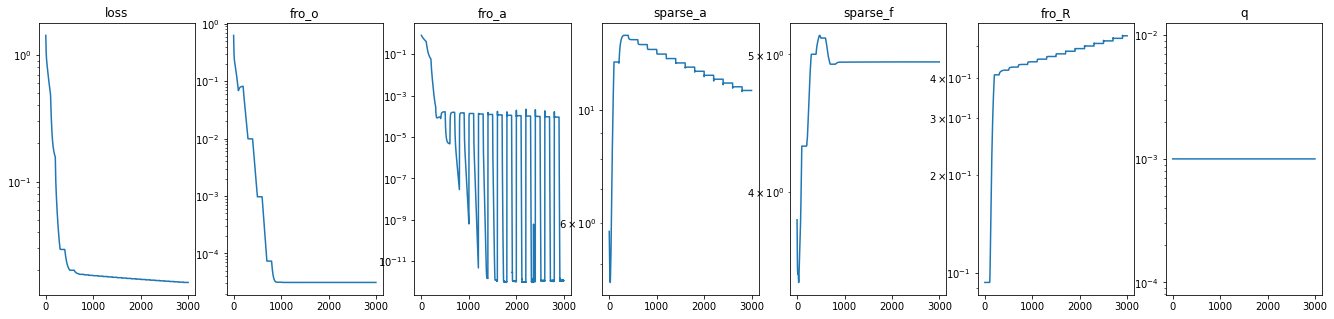

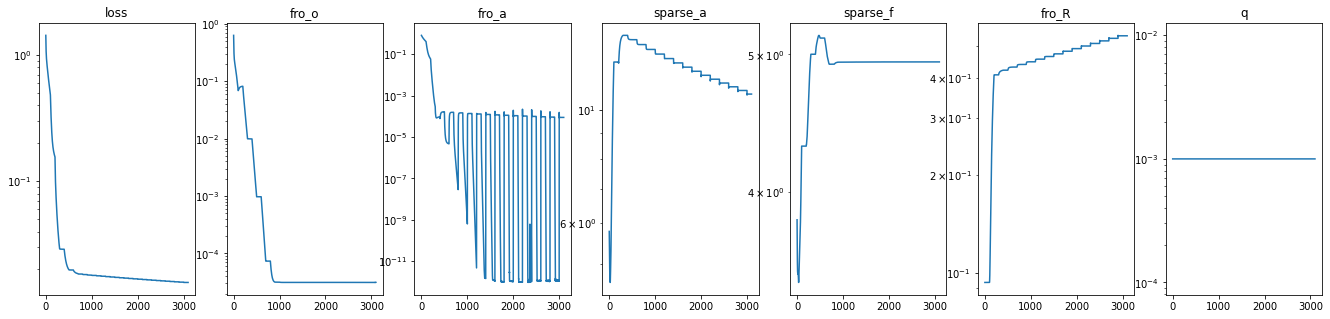

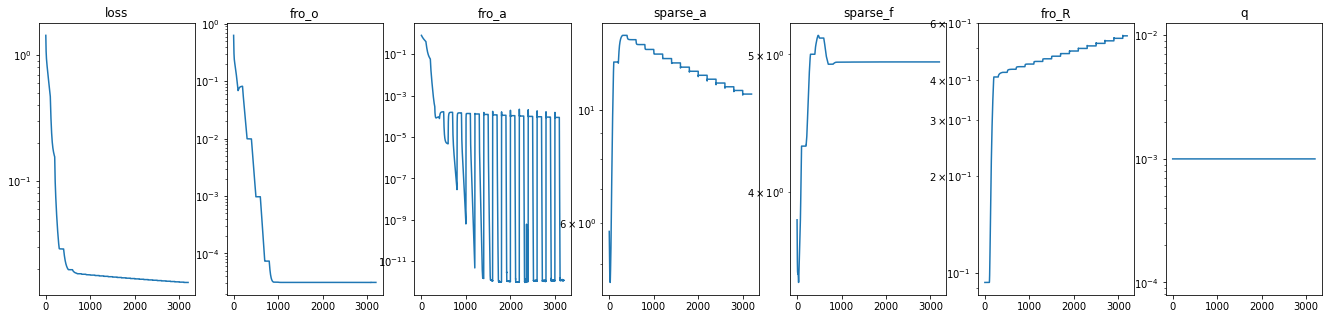

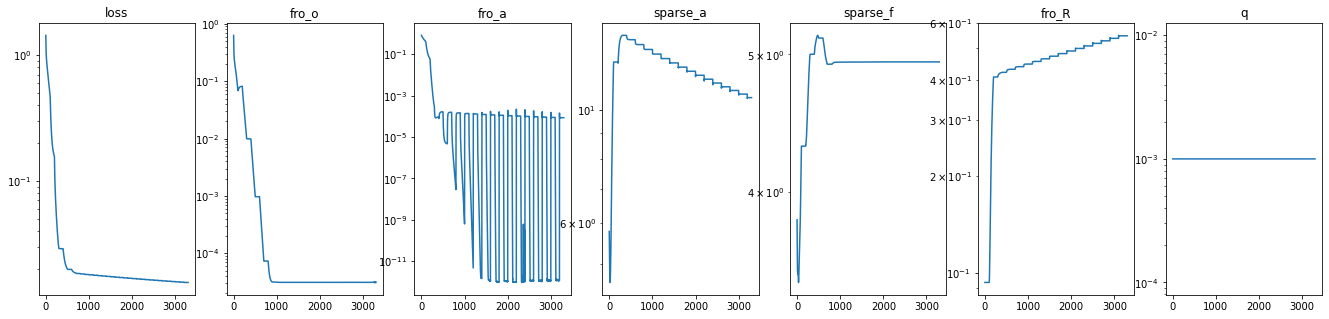

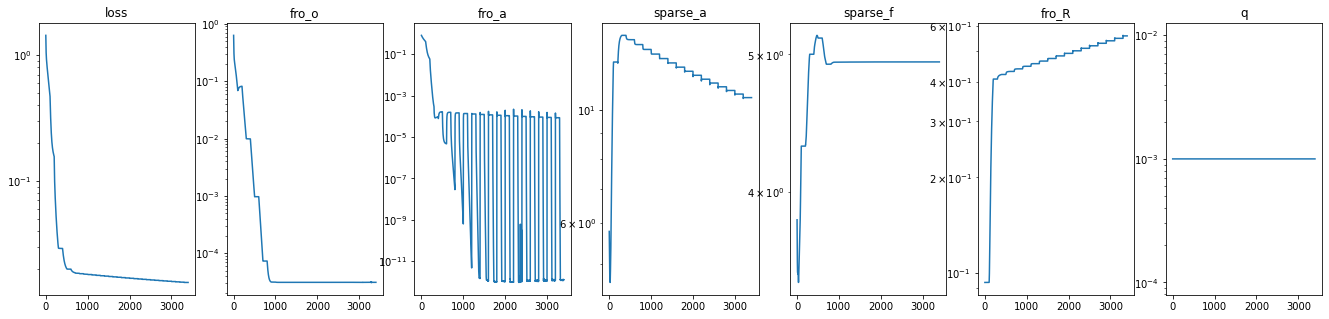

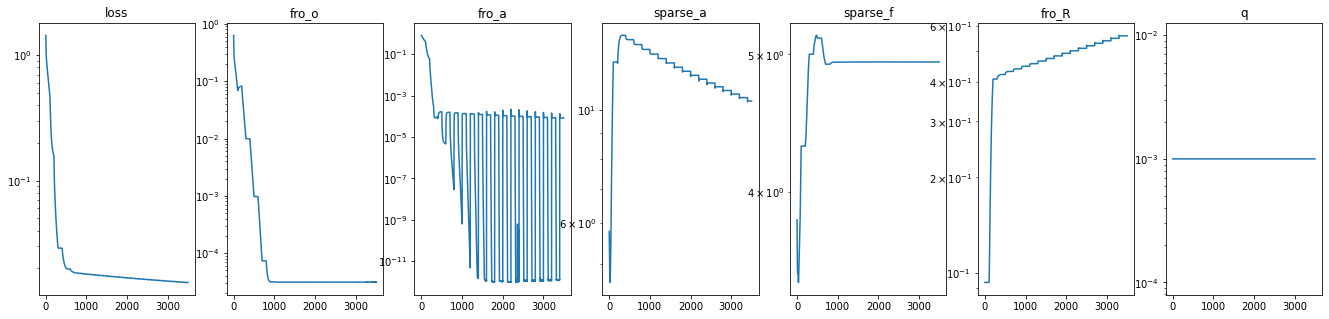

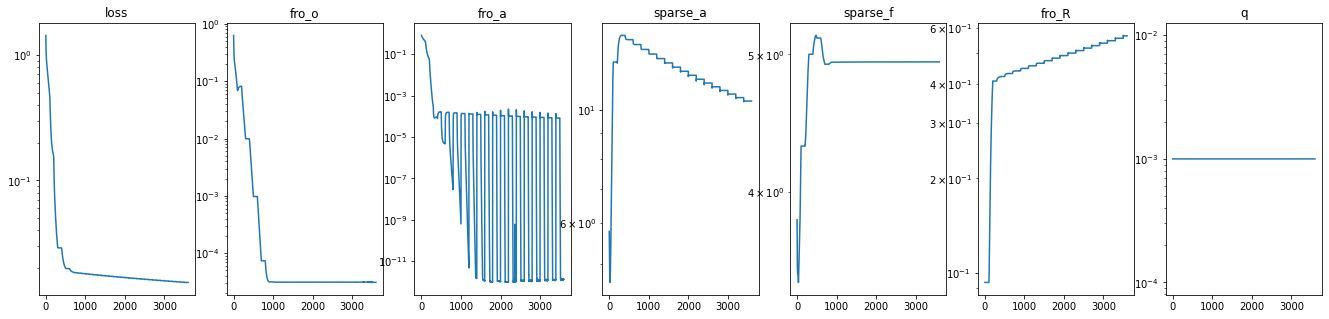

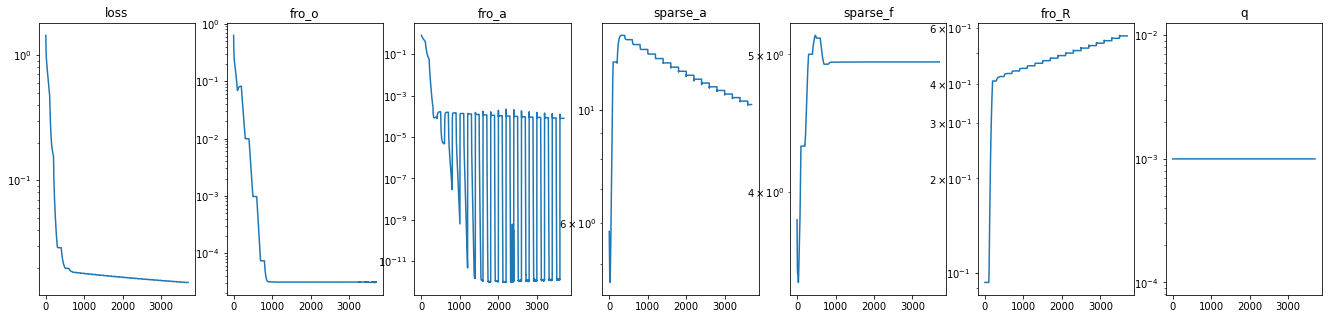

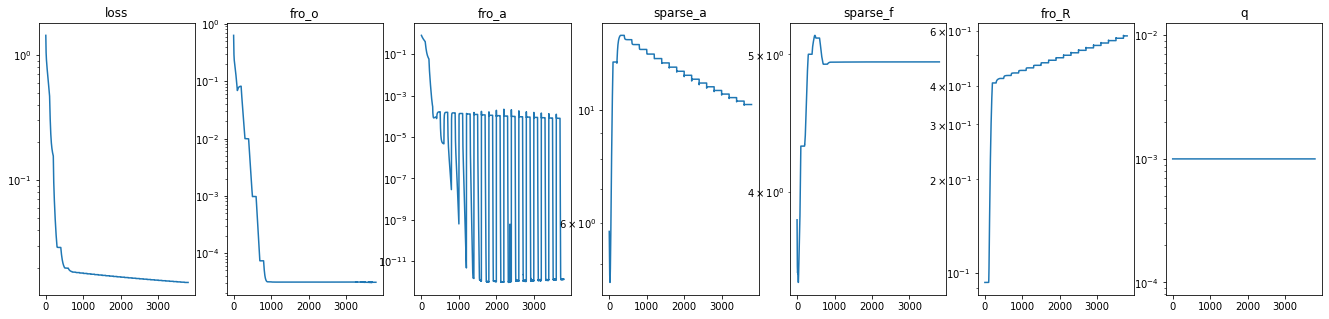

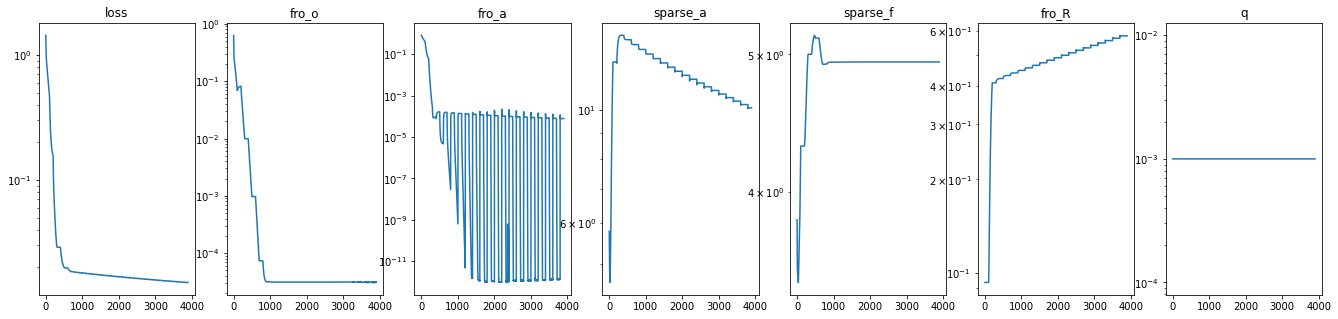

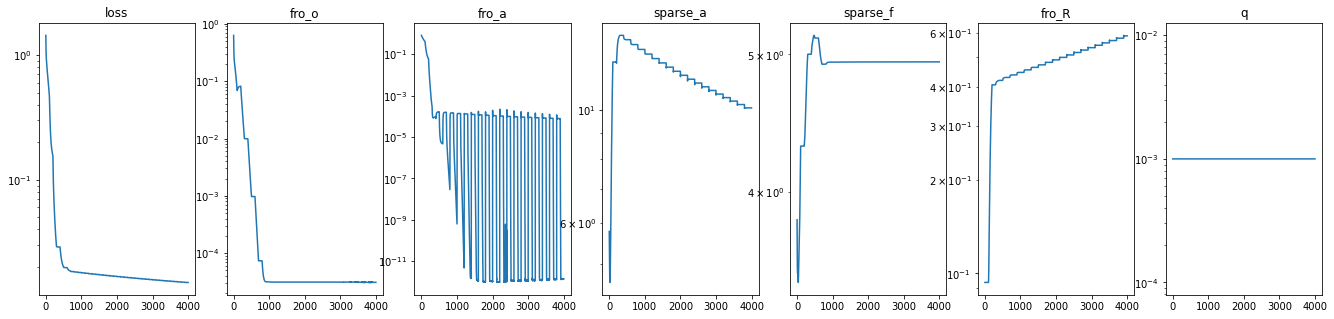

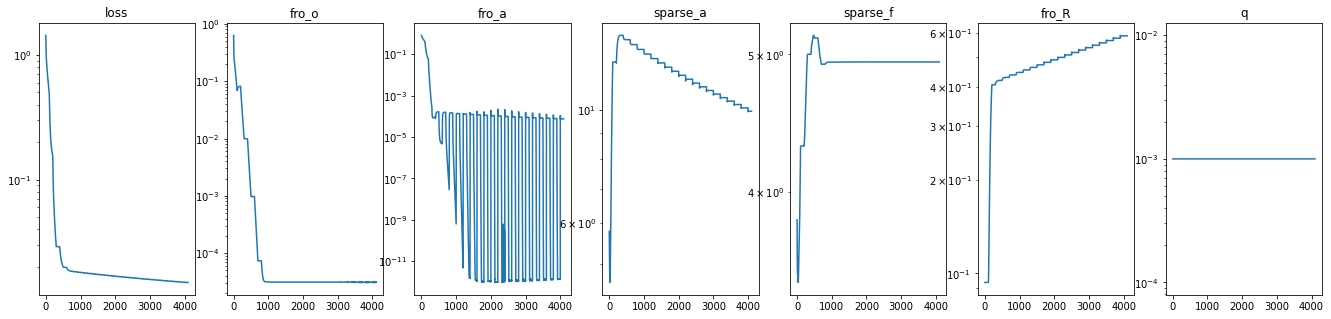

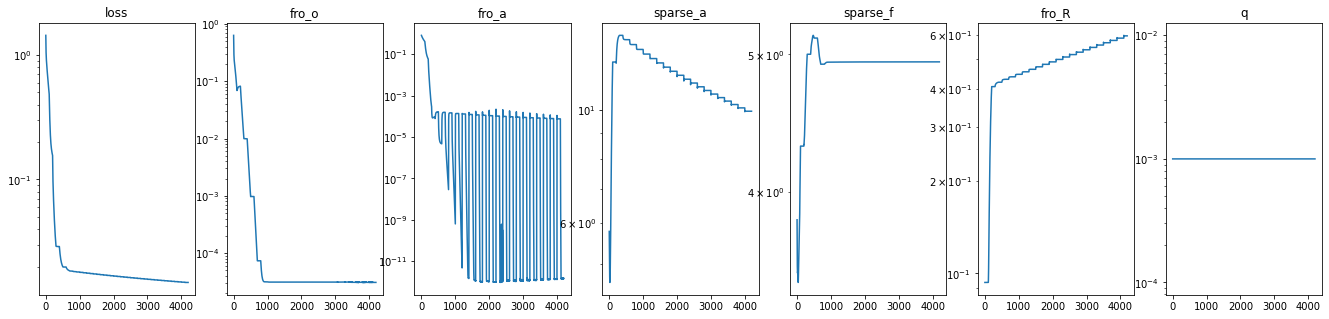

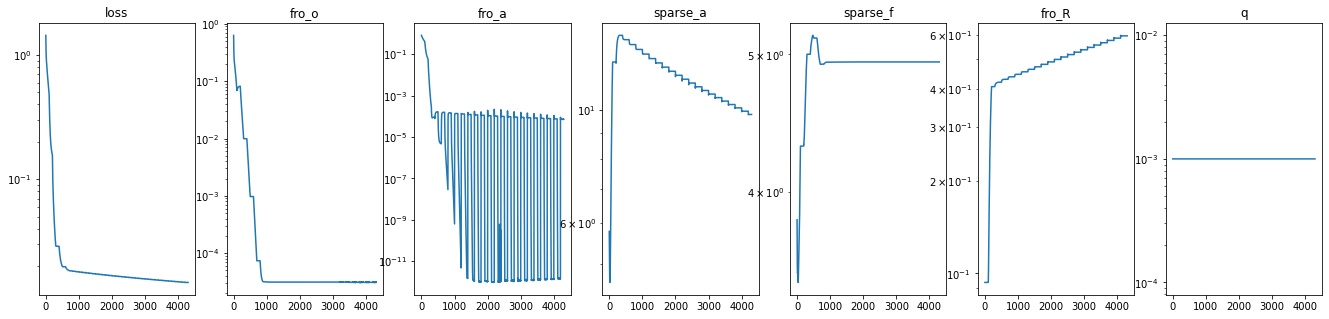

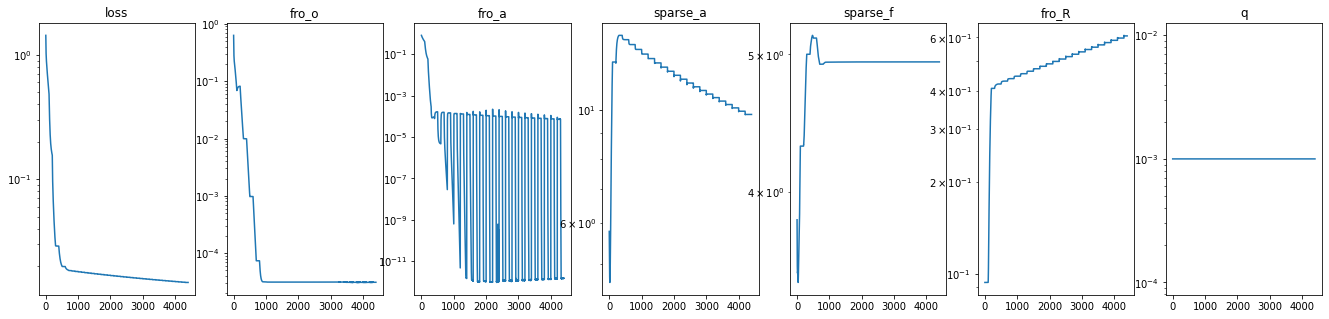

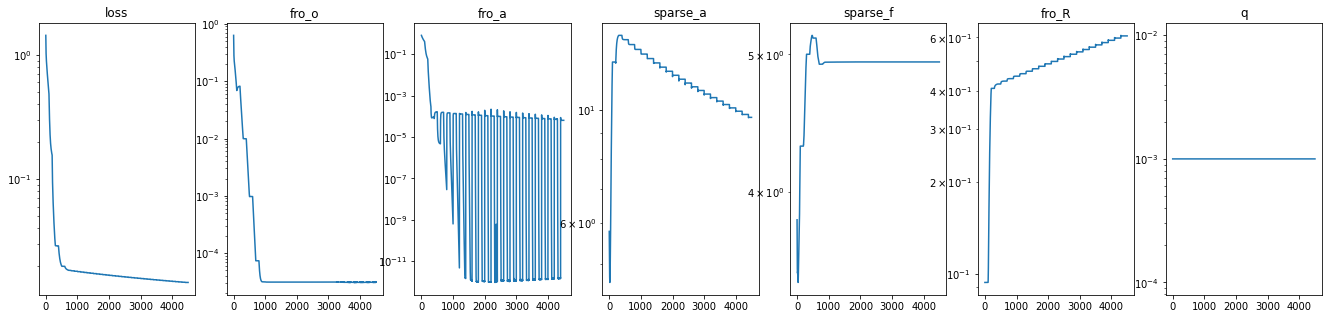

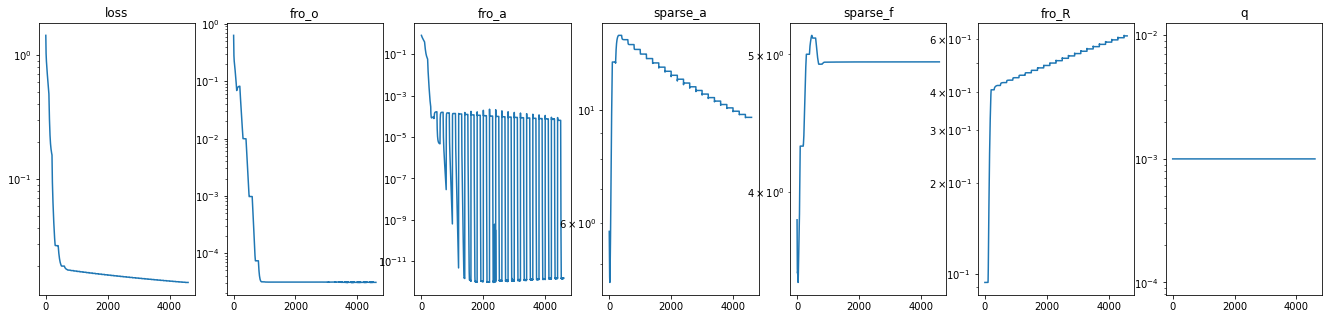

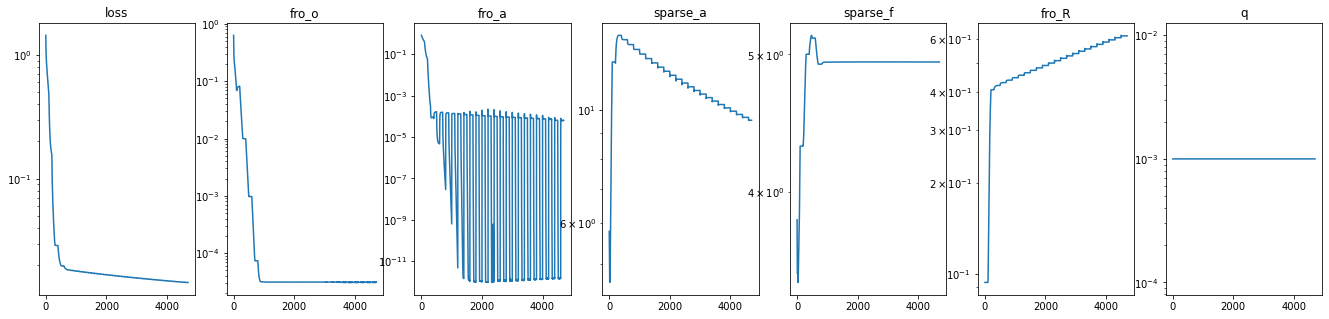

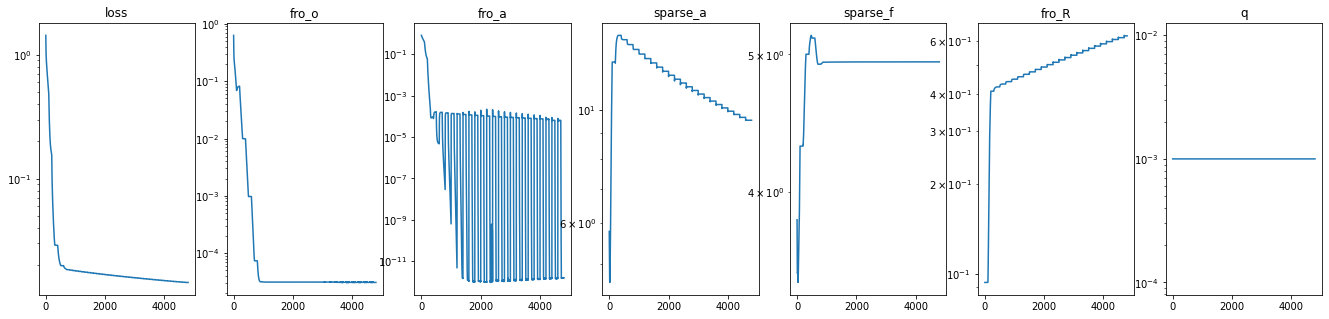

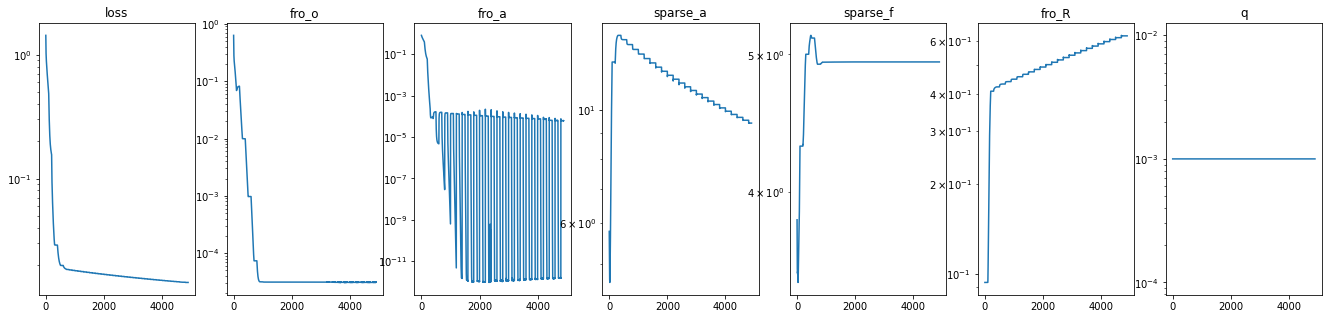

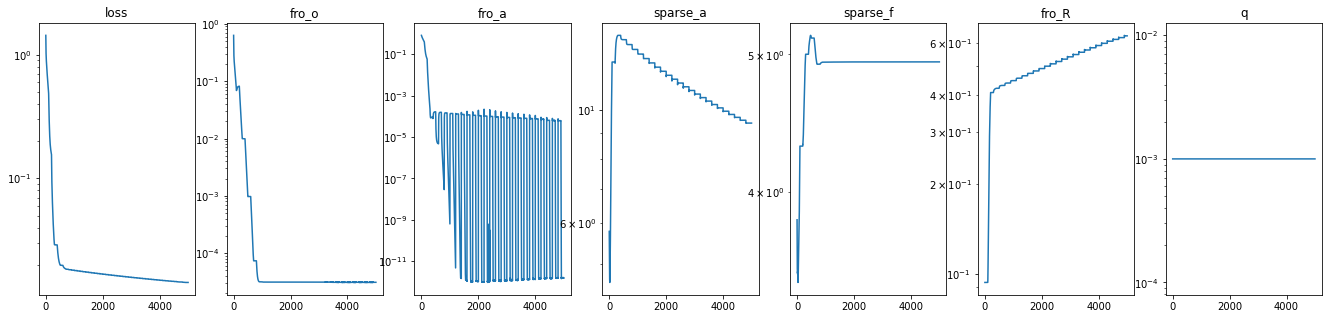

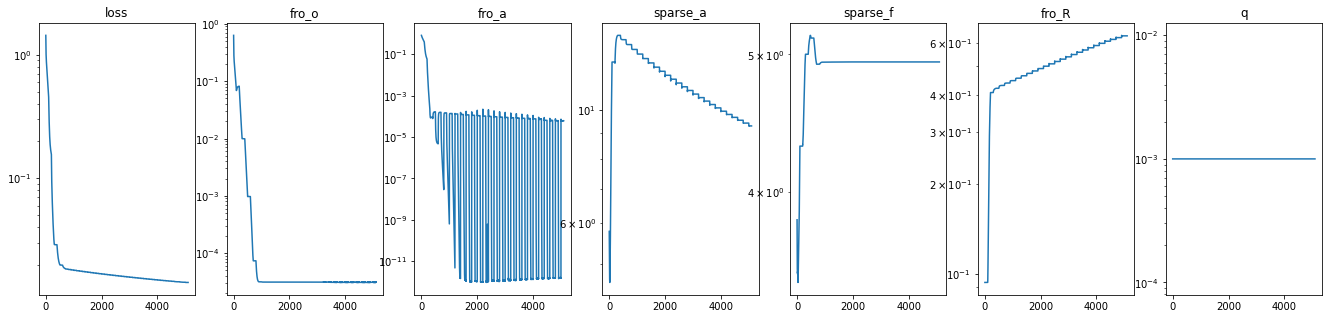

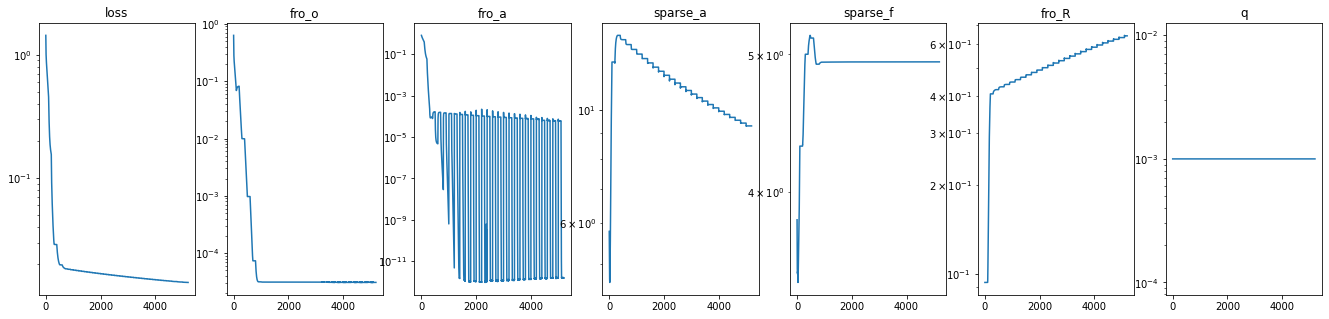

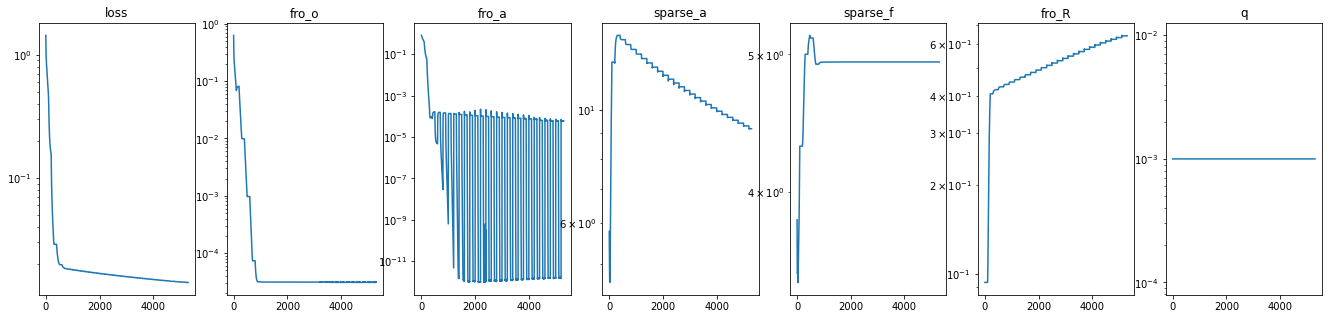

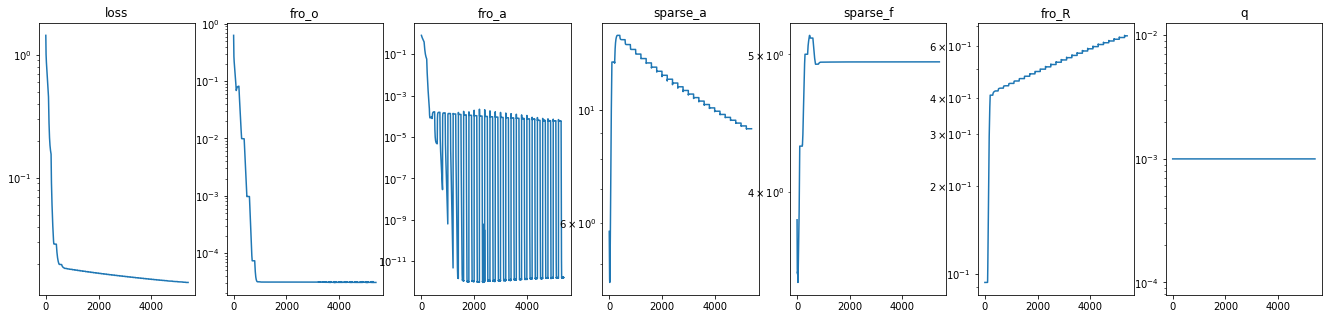

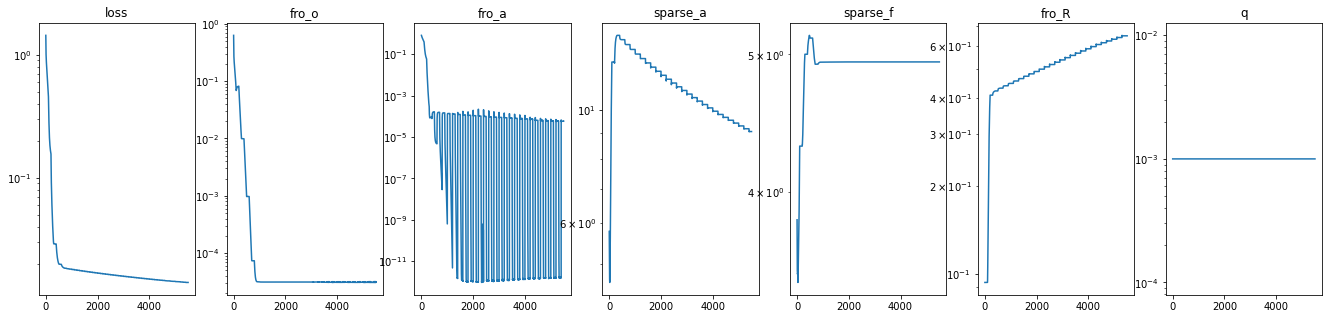

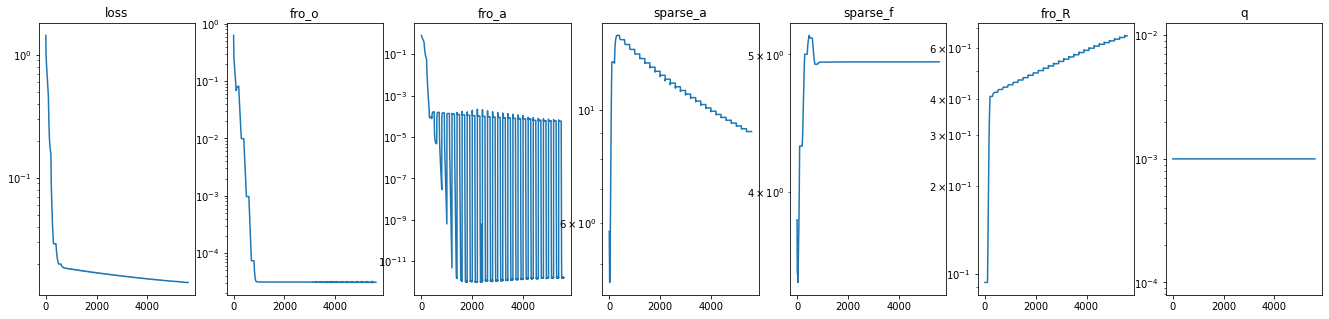

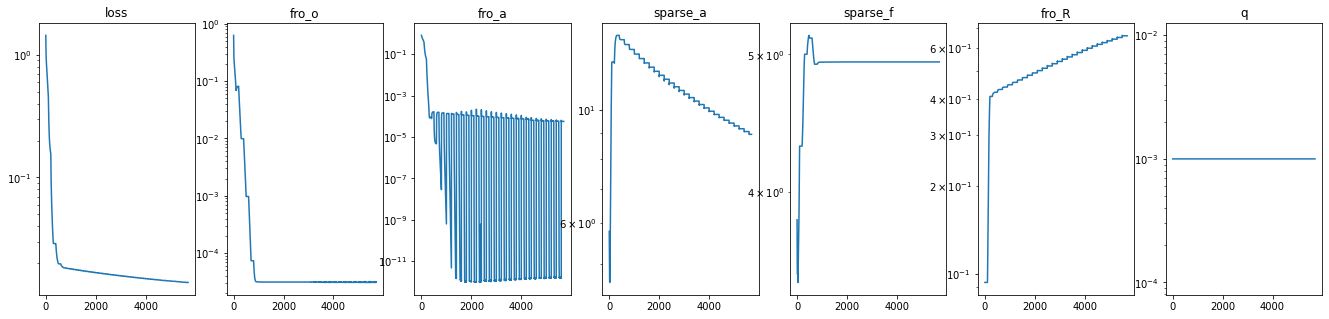

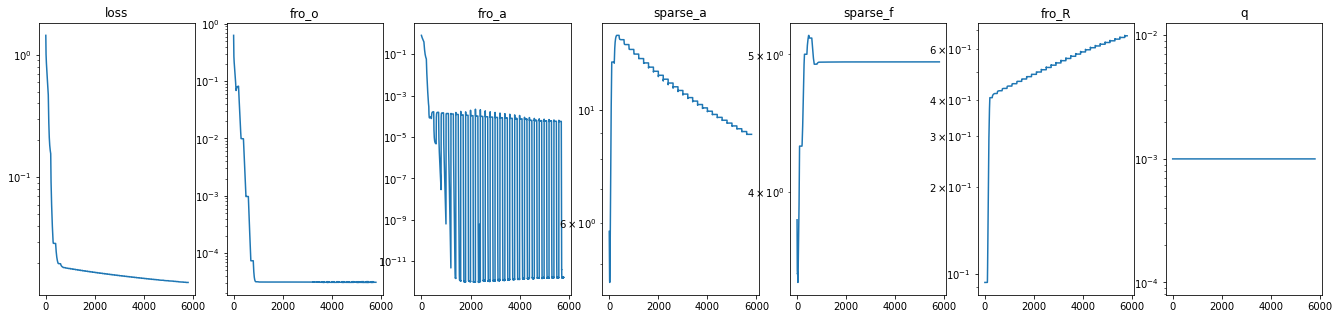

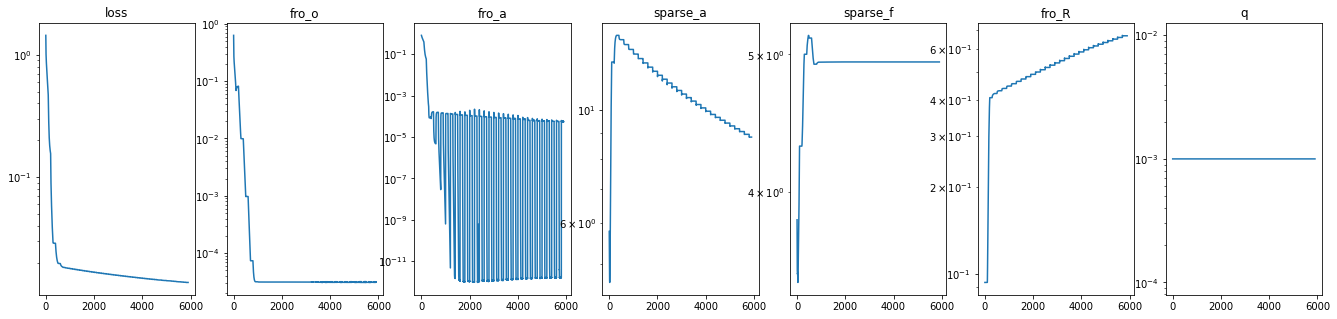

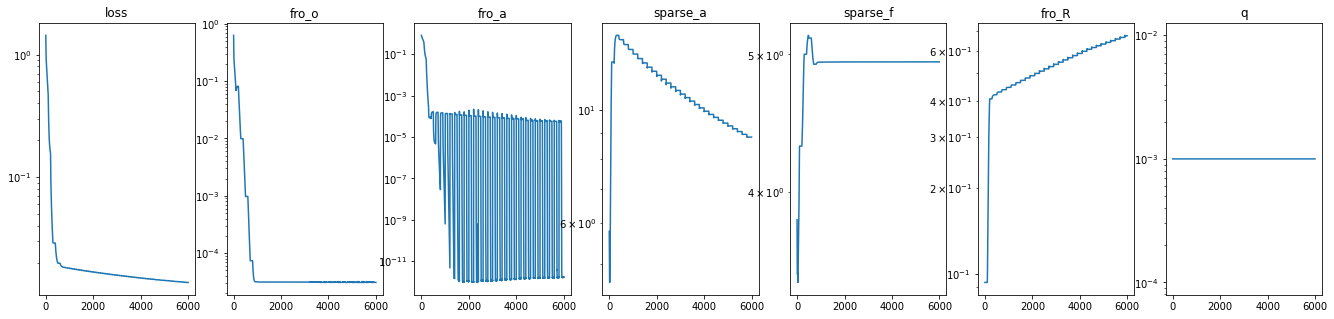

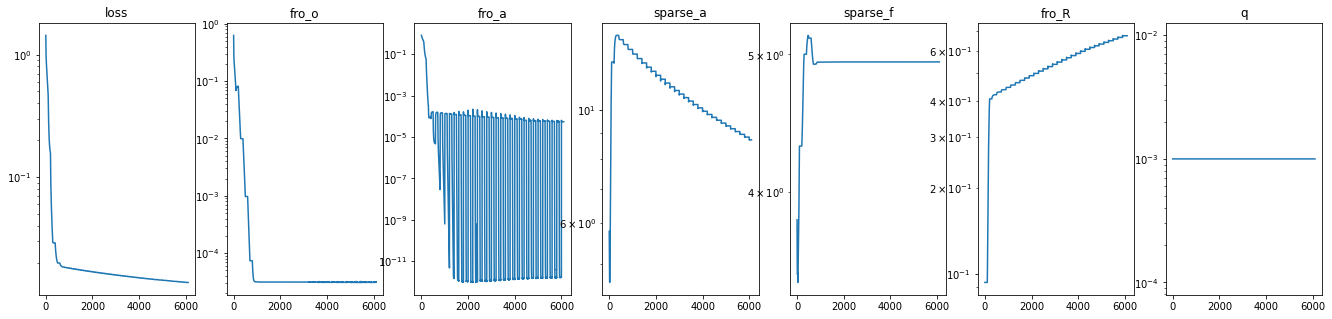

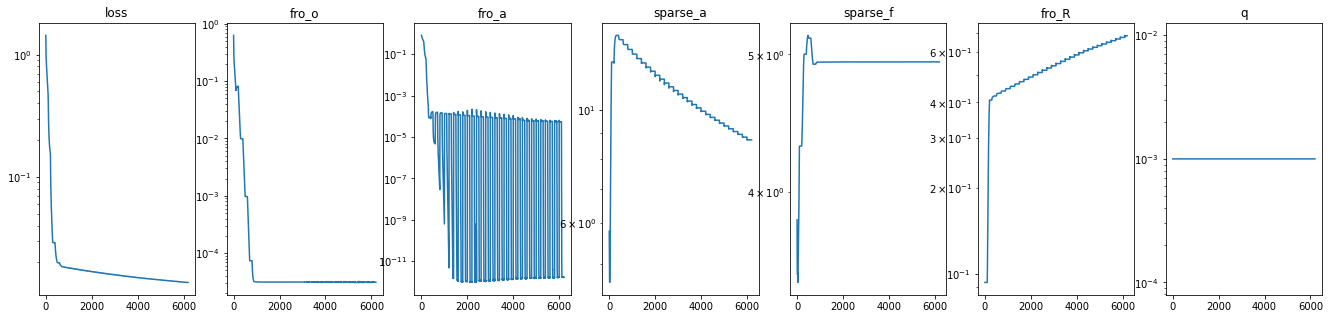

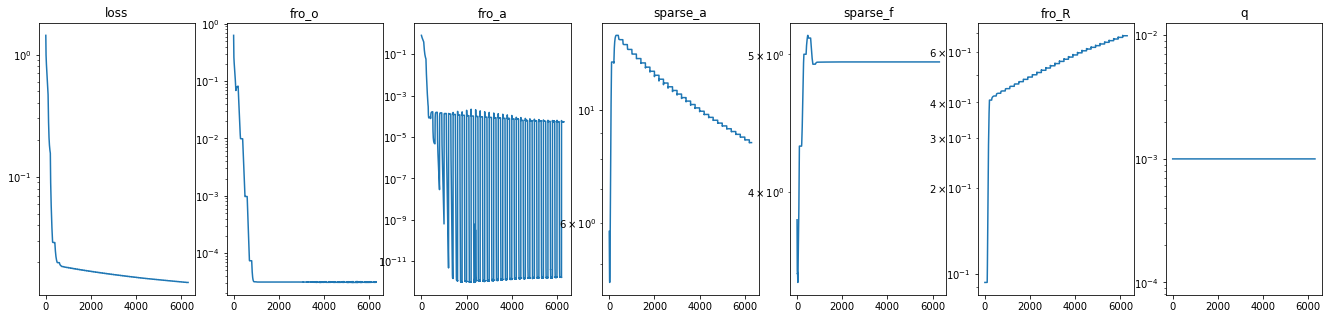

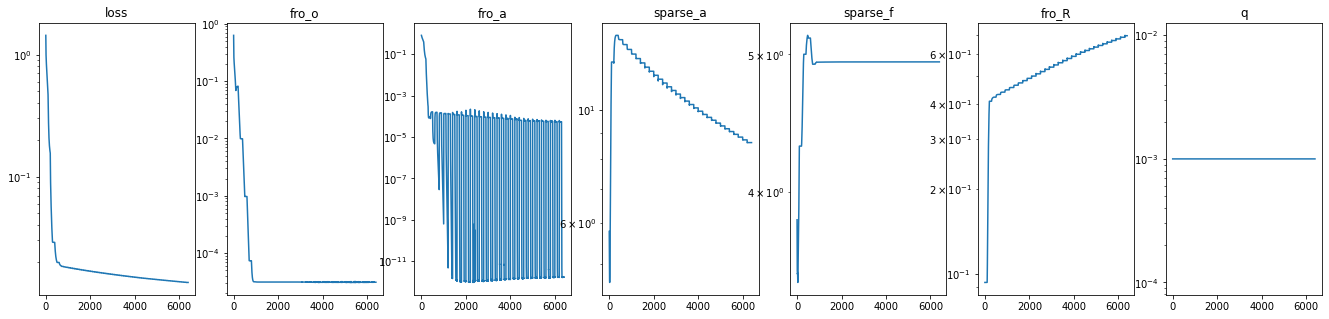

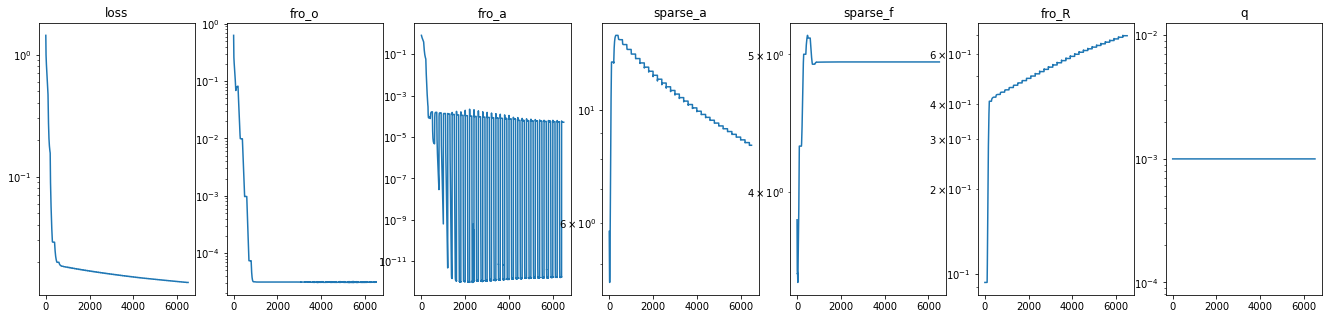

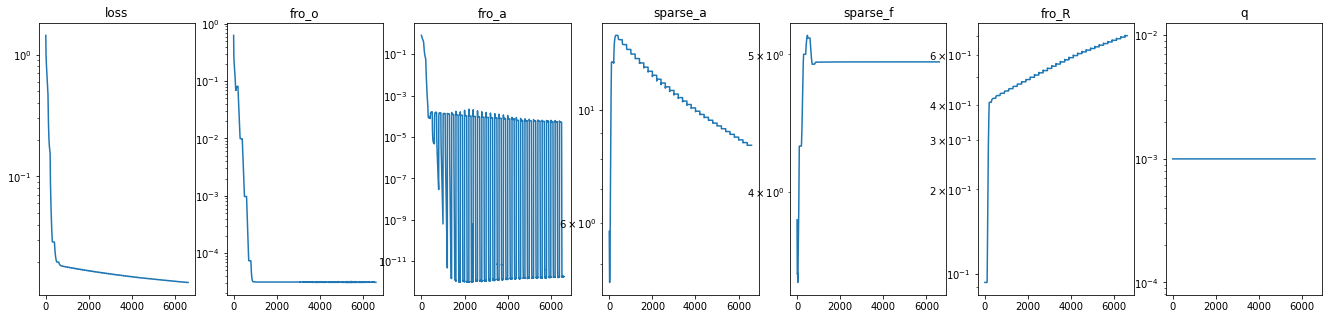

KeyboardInterrupt: 

In [141]:
q = 1e-3


for i in tqdm(range(100)):
    opt = [opt1, opt2][i % 2]
    for _ in tqdm(range(1000), leave=False):
        opt.zero_grad()

        R = reconstructor.fc.weight
        Rinv = torch.pinverse(R)

        Ma = model.fc_action.weight
        Mf = model.fc_features.weight

        deltaO = Wo_torch - R @ Mf @ Rinv
        deltaA = Wa_torch - R @ Ma

        sparse_a = torch.norm(Ma.flatten(), p=1)# / torch.max(torch.abs(Ma))
        sparse_f = torch.norm(Mf.flatten(), p=1)# / torch.max(torch.abs(Mf))

        fro_o = torch.mean(torch.square(deltaO))
        fro_a = torch.mean(torch.square(deltaA))

        fro_R = torch.mean(torch.square(R))

        loss = fro_o + fro_a + q * (sparse_a + sparse_f) + fro_R * 1e-6
        if epoch % 10 == 0:
            add_loss('loss', loss.item())
            add_loss('fro_o', fro_o.item())
            add_loss('fro_a', fro_a.item())
            add_loss('sparse_a', sparse_a.item())
            add_loss('sparse_f', sparse_f.item())
            add_loss('fro_R', fro_R.item())
            add_loss('q', q)
        epoch += 1
        
        loss.backward()
        opt.step()
  
#         q = max(1e-15, pid(fro_o.item() + fro_a.item() - 1e-5))
#         q = 1 / (fro_o.item() + fro_a.item())/ 100

#         if fro_o.item() + fro_a.item() > 1e-2:
#             q = 1e-10
# #             q *= 0.5
# #             if q < 1e-5:
# #                 q = 1e-5
#         else:
#             q /= 0.5
#             if q > 1e5:
#                 q = 1e5
            
    plt.figure(figsize=(23, 5))

    for i, (key, arr) in enumerate(losses.items(), 1):
        plt.subplot(1, len(losses), i)
        plt.title(key)
        plt.yscale('log')
        plt.plot(arr, label=key)
    #plt.yscale('log')
    #plt.legend()
    plt.show()

In [ ]:
sparse_a, sparse_f, fro_o, fro_a, fro_R, loss

In [ ]:
plt.figure(figsize=(23, 5))

for i, (key, arr) in enumerate(losses.items(), 1):
    plt.subplot(1, len(losses), i)
    plt.title(key)
#     plt.yscale('log')
    plt.plot(arr, label=key)
#plt.yscale('log')
#plt.legend()
plt.show()

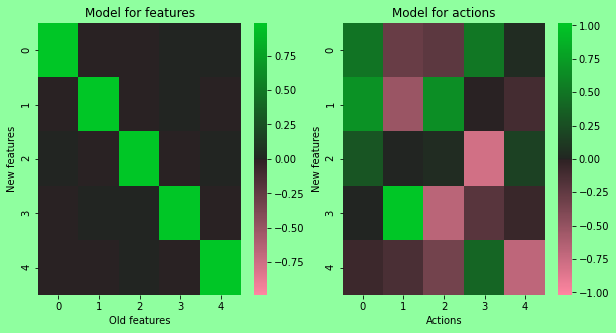

In [142]:
_ = plot_model(model)

In [ ]:
Mf

In [ ]:
!pip install simple-pid

In [ ]:
sns.heatmap(Wa)

In [ ]:
torch.norm(R, dim=0)

In [ ]:
?torch.norm